This example makes a station plot, complete with sky cover and weather symbols. The station plot itself is pretty straightforward, but there is a bit of code to perform the data-wrangling (hopefully that situation will improve in the future). Certainly, if you have existing point data in a format you can work with trivially, the station plot will be simple.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units

%matplotlib inline

In [2]:
# Utility function for working with the text data we get back in arrays
def make_string_list(arr):
    return [s.decode('ascii') for s in arr]

# The setup

First read in the data. We use `numpy.loadtxt` to read in the data and use a structured `numpy.dtype` to allow different types for the various columns. This allows us to handle the columns with string data.

In [3]:
f = get_test_data('station_data.txt')

all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                      usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                      dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                      ('slp', 'f'), ('air_temperature', 'f'),
                                      ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                      ('weather', '16S'),
                                      ('wind_dir', 'f'), ('wind_speed', 'f')]))

This sample data has *way* too many stations to plot all of them. Instead, we just select a few from around the U.S. and pull those out of the data file.

In [4]:
# Get the full list of stations in the data
all_stids = make_string_list(all_data['stid'])

# Pull out these specific stations
whitelist = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
             'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
             'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
             'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
             'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

# Loop over all the whitelisted sites, grab the first data, and concatenate them
data = np.concatenate([all_data[all_stids.index(site)].reshape(1,) for site in whitelist])

Now that we have the data we want, we need to perform some conversions:
- Get a list of strings for the station IDs
- Get wind components from speed and direction
- Convert cloud fraction values to integer codes [0 - 8]
- Map METAR weather codes to WMO codes for weather symbols

In [5]:
# Get all of the station IDs as a list of strings
stid = make_string_list(data['stid'])

# Get the wind components, converting from m/s to knots as will be appropriate
# for the station plot
u, v = get_wind_components((data['wind_speed'] * units('m/s')).to('knots'),
                           data['wind_dir'] * units.degree)

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
cloud_frac = (8 * data['cloud_fraction']).astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
wx_text = make_string_list(data['weather'])
wx_codes = {'':0, 'HZ':5, 'BR':10, '-DZ':51, 'DZ':53, '+DZ':55,
            '-RA':61, 'RA':63, '+RA':65, '-SN':71, 'SN':73, '+SN':75}
wx = [wx_codes[s.split()[0] if ' ' in s else s] for s in wx_text]

Now all the data wrangling is finished, just need to set up plotting and go

In [6]:
# Set up the map projection and set up a cartopy feature for state borders
import cartopy.crs as ccrs
import cartopy.feature as feat
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='110m', facecolor='none')

In [7]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering
from matplotlib import rcParams
rcParams['savefig.dpi'] = 255

# The payoff

/Users/jleeman/anaconda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/jleeman/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/jleeman/anaconda/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


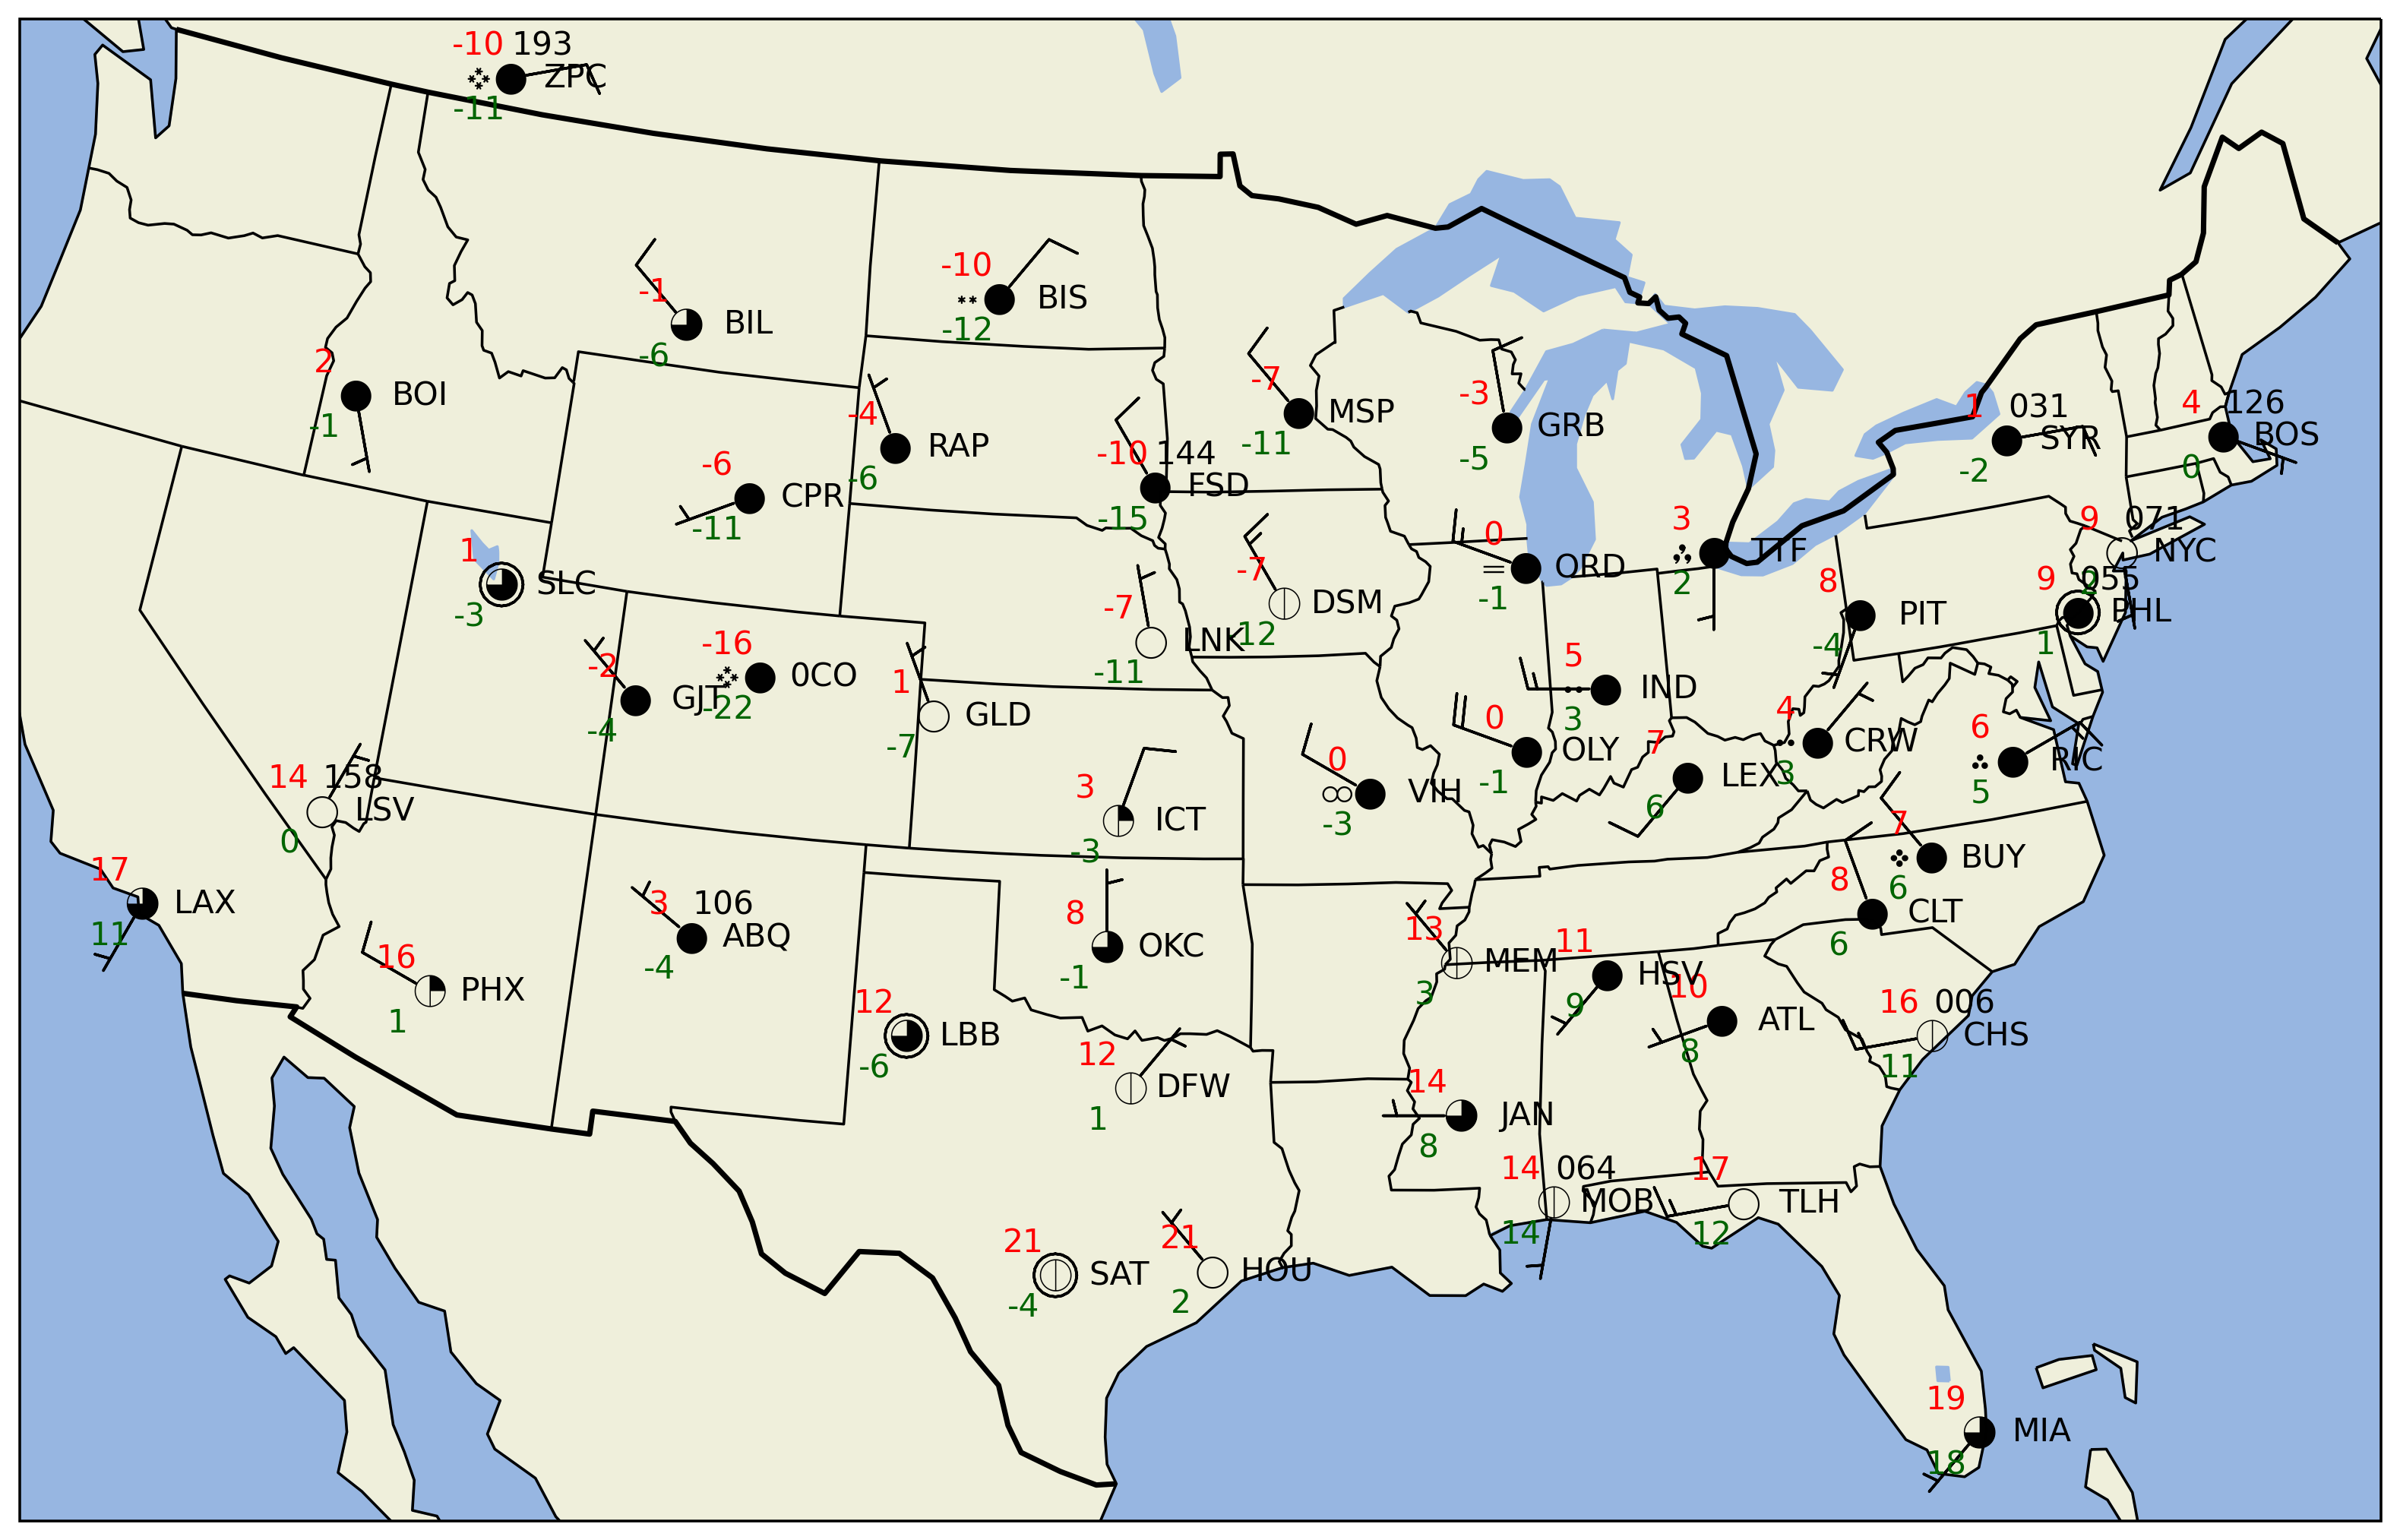

In [8]:
# Create the figure and an axes set to the projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['lon'], data['lat'], transform=ccrs.PlateCarree(),
                          fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'], color='red')
stationplot.plot_parameter('SW', data['dewpoint'], color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['slp'],
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', cloud_frac, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', wx, current_weather)

# Add wind barbs
stationplot.plot_barb(u, v)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), stid)